In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import singletask_dep as st
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'pos'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [13]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [14]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6796732807616324 	 Validation loss: 0.6793861156803066 	 
  1%|          | 574/57400 [00:06<09:20, 101.32it/s]
Epoch 2 	 Training loss: 0.6678009860814657 	 Validation loss: 0.6641951344781003 	 
  2%|▏         | 1148/57400 [00:12<09:23, 99.77it/s]
Epoch 3 	 Training loss: 0.6541433911705682 	 Validation loss: 0.6516396908436791 	 
  3%|▎         | 1722/57400 [00:18<09:16, 100.03it/s]
Epoch 4 	 Training loss: 0.644802703674662 	 Validation loss: 0.6461242528285011 	 
  4%|▍         | 2296/57400 [00:24<08:54, 103.09it/s]
Epoch 5 	 Training loss: 0.6366097415158142 	 Validation loss: 0.6331853674629987 	 
  5%|▌         | 2870/57400 [00:31<08:50, 102.75it/s]
Epoch 6 	 Training loss: 0.6286034519664087 	 Validation loss: 0.6263063661122726 	 
  6%|▌         | 3444/57400 [00:37<08:38, 104.16it/s]
Epoch 7 	 Training loss: 0.6207347080267265 	 Validation loss: 0.618704421035314 	 
  7%|▋         | 4018/57400 [00:43<08:58, 99.14it/s]
Epoch 8 	 Training loss: 0.61344

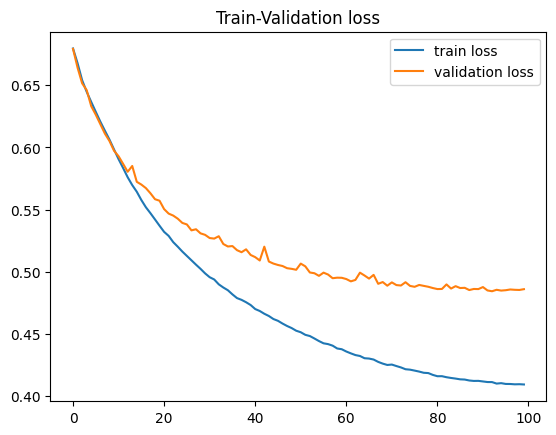

In [15]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7232142857142857, 'precision': 0.7232142857142857, 'f1': 0.7232142857142857, 'accuracy': 0.7232142857142857}
MALE {'recall': 0.7994791666666666, 'precision': 0.7994791666666666, 'f1': 0.7994791666666666, 'accuracy': 0.7994791666666666}
FEMALE {'recall': 0.65, 'precision': 0.65, 'f1': 0.65, 'accuracy': 0.65} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5820707070707071, 'precision': 0.5820707070707071, 'f1': 0.5820707070707071, 'accuracy': 0.5820707070707071}
MALE {'recall': 0.6788321167883211, 'precision': 0.6788321167883211, 'f1': 0.6788321167883211, 'accuracy': 0.6788321167883211}
FEMALE {'recall': 0.4776902887139108, 'precision': 0.4776902887139108, 'f1': 0.4776902887139108, 'accuracy': 0.4776902887139108} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5945241199478487, 'precision': 0.5945241199478487, 'f1': 0.5945241199478487, 'accuracy': 0.5945241199478487}
MALE {'recall': 0.654040

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6804067353338314 	 Validation loss: 0.679379818803173 	 
  1%|          | 574/57400 [00:05<09:08, 103.57it/s]
Epoch 2 	 Training loss: 0.6673524452418815 	 Validation loss: 0.6619494900865069 	 
  2%|▏         | 1148/57400 [00:12<09:00, 104.04it/s]
Epoch 3 	 Training loss: 0.6546770853447997 	 Validation loss: 0.6553890048447302 	 
  3%|▎         | 1722/57400 [00:18<08:49, 105.21it/s]
Epoch 4 	 Training loss: 0.6472363015085147 	 Validation loss: 0.6507029816255732 	 
  4%|▍         | 2296/57400 [00:24<08:48, 104.22it/s]
Epoch 5 	 Training loss: 0.6402831648700329 	 Validation loss: 0.6450918892682609 	 
  5%|▌         | 2870/57400 [00:30<08:31, 106.52it/s]
Epoch 6 	 Training loss: 0.6331042057545758 	 Validation loss: 0.6400089779142606 	 
  6%|▌         | 3444/57400 [00:36<08:38, 103.98it/s]
Epoch 7 	 Training loss: 0.6264030967647606 	 Validation loss: 0.637547017154047 	 
  7%|▋         | 4018/57400 [00:42<08:30, 104.52it/s]
Epoch 8 	 Training loss: 0.619

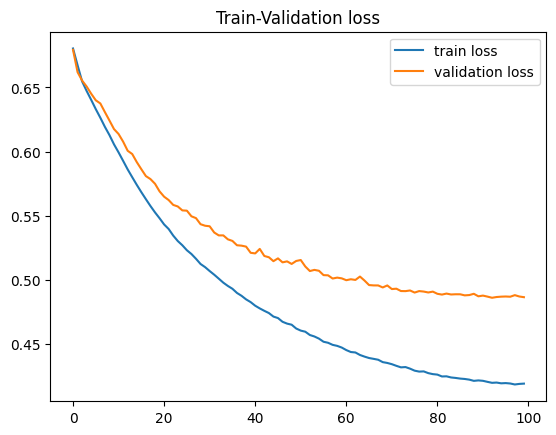

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7142857142857143, 'precision': 0.7142857142857143, 'f1': 0.7142857142857143, 'accuracy': 0.7142857142857143}
MALE {'recall': 0.8333333333333334, 'precision': 0.8333333333333334, 'f1': 0.8333333333333334, 'accuracy': 0.8333333333333334}
FEMALE {'recall': 0.6, 'precision': 0.6, 'f1': 0.6, 'accuracy': 0.6} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5959595959595959, 'precision': 0.5959595959595959, 'f1': 0.5959595959595959, 'accuracy': 0.5959595959595959}
MALE {'recall': 0.7153284671532847, 'precision': 0.7153284671532847, 'f1': 0.7153284671532847, 'accuracy': 0.7153284671532847}
FEMALE {'recall': 0.4671916010498688, 'precision': 0.4671916010498688, 'f1': 0.4671916010498688, 'accuracy': 0.4671916010498688} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5840938722294654, 'precision': 0.5840938722294654, 'f1': 0.5840938722294654, 'accuracy': 0.5840938722294654}
MALE {'recall': 0.6868686868

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6783983924455343 	 Validation loss: 0.6741438376701484 	 
  1%|          | 574/57400 [00:05<09:30, 99.54it/s]
Epoch 2 	 Training loss: 0.6574719227357193 	 Validation loss: 0.6532292790332083 	 
  2%|▏         | 1148/57400 [00:12<09:25, 99.53it/s]
Epoch 3 	 Training loss: 0.6453364990937169 	 Validation loss: 0.6458324032314753 	 
  3%|▎         | 1722/57400 [00:18<09:08, 101.59it/s]
Epoch 4 	 Training loss: 0.637900056116257 	 Validation loss: 0.6407683946318545 	 
  4%|▍         | 2296/57400 [00:24<09:03, 101.37it/s]
Epoch 5 	 Training loss: 0.630760906153855 	 Validation loss: 0.6345455100980856 	 
  5%|▌         | 2870/57400 [00:30<08:49, 103.00it/s]
Epoch 6 	 Training loss: 0.6239542913353817 	 Validation loss: 0.629942559589774 	 
  6%|▌         | 3444/57400 [00:36<08:58, 100.24it/s]
Epoch 7 	 Training loss: 0.6170923061902515 	 Validation loss: 0.6232859482199459 	 
  7%|▋         | 4018/57400 [00:42<08:44, 101.70it/s]
Epoch 8 	 Training loss: 0.610154

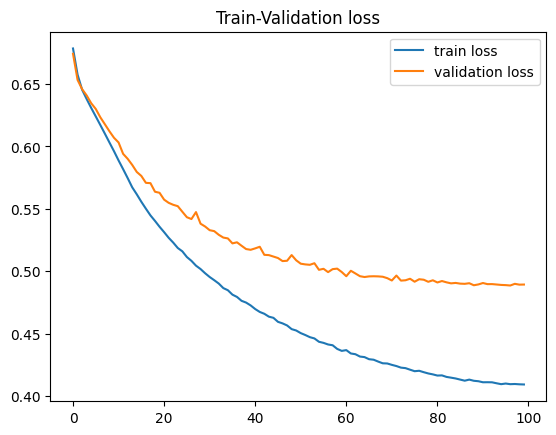

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7142857142857143, 'precision': 0.7142857142857143, 'f1': 0.7142857142857143, 'accuracy': 0.7142857142857143}
MALE {'recall': 0.796875, 'precision': 0.796875, 'f1': 0.796875, 'accuracy': 0.796875}
FEMALE {'recall': 0.635, 'precision': 0.635, 'f1': 0.635, 'accuracy': 0.635} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5921717171717171, 'precision': 0.5921717171717171, 'f1': 0.5921717171717171, 'accuracy': 0.5921717171717171}
MALE {'recall': 0.6861313868613139, 'precision': 0.6861313868613139, 'f1': 0.6861313868613139, 'accuracy': 0.6861313868613139}
FEMALE {'recall': 0.49081364829396323, 'precision': 0.49081364829396323, 'f1': 0.49081364829396323, 'accuracy': 0.49081364829396323} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5919165580182529, 'precision': 0.5919165580182529, 'f1': 0.5919165580182529, 'accuracy': 0.5919165580182529}
MALE {'recall': 0.6363636363636364, 'precision': 0.63636

In [21]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7172619047619048, 'precision': 0.7172619047619048, 'f1': 0.7172619047619048, 'accuracy': 0.7172619047619048}
Métricas etiqueta male: {'recall': 0.8098958333333334, 'precision': 0.8098958333333334, 'f1': 0.8098958333333334, 'accuracy': 0.8098958333333334}
Métricas etiqueta female:  {'recall': 0.6283333333333333, 'precision': 0.6283333333333333, 'f1': 0.6283333333333333, 'accuracy': 0.6283333333333333}

 to
Resultado global: {'recall': 0.5900673400673401, 'precision': 0.5900673400673401, 'f1': 0.5900673400673401, 'accuracy': 0.5900673400673401}
Métricas etiqueta male: {'recall': 0.6934306569343066, 'precision': 0.6934306569343066, 'f1': 0.6934306569343066, 'accuracy': 0.6934306569343066}
Métricas etiqueta female:  {'recall': 0.4785651793525809, 'precision': 0.4785651793525809, 'f1': 0.4785651793525809, 'accuracy': 0.4785651793525809}

 as
Resultado global: {'recall': 0.5901781833985223, 'precision': 0.5901781833985223, 'f1': 0.5

## TO

In [22]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932855361637753 	 Validation loss: 0.6927490719294144 	 
  1%|          | 574/57400 [00:06<10:01, 94.43it/s]
Epoch 2 	 Training loss: 0.6933065998637302 	 Validation loss: 0.6934408575801526 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<10:00, 93.60it/s]
Epoch 3 	 Training loss: 0.6930667516038809 	 Validation loss: 0.6946802058462369 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:19<10:03, 92.26it/s]
Epoch 4 	 Training loss: 0.6932488387054683 	 Validation loss: 0.692944907535941 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:26<09:48, 93.69it/s]
Epoch 5 	 Training loss: 0.6931040523774948 	 Validation loss: 0.6934090640585301 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:33<09:46, 92.93it/s]
Epoch 6 	 Training loss: 0.6929482694079236 	 Validation loss: 0.6926764118469367 	 
  6%|▌         | 3444/57400 [00:39<09:43, 92.53it/s]
Epoch 7 	 Training loss: 0.6930526594667069 	 Validation l

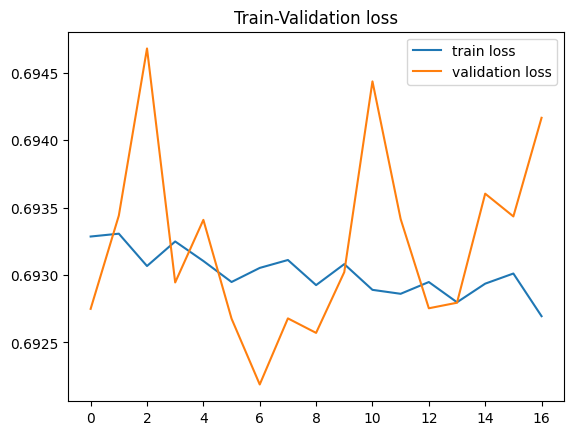

In [23]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5114795918367347, 'precision': 0.5114795918367347, 'f1': 0.5114795918367347, 'accuracy': 0.5114795918367347}
MALE {'recall': 0.2421875, 'precision': 0.2421875, 'f1': 0.2421875, 'accuracy': 0.2421875}
FEMALE {'recall': 0.77, 'precision': 0.77, 'f1': 0.7699999999999999, 'accuracy': 0.77} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.1922141119221411, 'precision': 0.1922141119221411, 'f1': 0.19221411192214113, 'accuracy': 0.1922141119221411}
FEMALE {'recall': 0.7926509186351706, 'precision': 0.7926509186351706, 'f1': 0.7926509186351706, 'accuracy': 0.7926509186351706} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4758800521512386, 'precision': 0.4758800521512386, 'f1': 0.4758800521512386, 'accuracy': 0.4758800521512386}
MALE {'recall': 0.1994949494949495, 'precisio

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933925447771359 	 Validation loss: 0.6933122580334291 	 
  1%|          | 574/57400 [00:06<10:11, 92.93it/s]
Epoch 2 	 Training loss: 0.6932242885491574 	 Validation loss: 0.6929395714048612 	 
  2%|▏         | 1148/57400 [00:13<10:15, 91.32it/s]
Epoch 3 	 Training loss: 0.6932129638743317 	 Validation loss: 0.6932199637768632 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:20<10:25, 88.94it/s]
Epoch 4 	 Training loss: 0.6931287695098837 	 Validation loss: 0.6918821243916528 	 
  4%|▍         | 2296/57400 [00:26<09:52, 92.98it/s]
Epoch 5 	 Training loss: 0.6932056289724357 	 Validation loss: 0.6941043178913957 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:33<09:46, 93.02it/s]
Epoch 6 	 Training loss: 0.6931680410788865 	 Validation loss: 0.6935304554842286 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:39<09:30, 94.53it/s]
Epoch 7 	 Training loss: 0.6931232549379926 	 Validation loss: 0.6928246263730324 	 



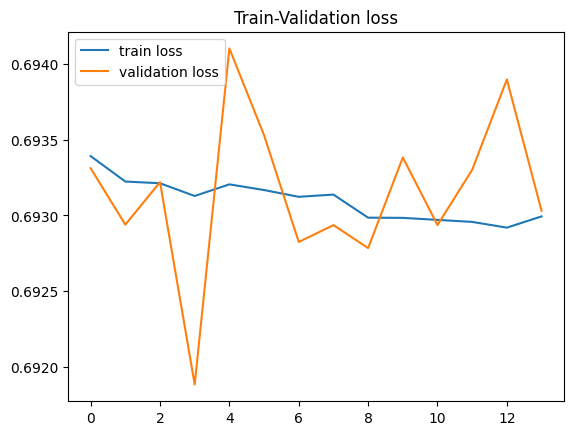

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.514030612244898, 'precision': 0.514030612244898, 'f1': 0.514030612244898, 'accuracy': 0.514030612244898}
MALE {'recall': 0.033854166666666664, 'precision': 0.033854166666666664, 'f1': 0.033854166666666664, 'accuracy': 0.033854166666666664}
FEMALE {'recall': 0.975, 'precision': 0.975, 'f1': 0.975, 'accuracy': 0.975} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48358585858585856, 'precision': 0.48358585858585856, 'f1': 0.48358585858585856, 'accuracy': 0.48358585858585856}
MALE {'recall': 0.019464720194647202, 'precision': 0.019464720194647202, 'f1': 0.019464720194647202, 'accuracy': 0.019464720194647202}
FEMALE {'recall': 0.984251968503937, 'precision': 0.984251968503937, 'f1': 0.984251968503937, 'accuracy': 0.984251968503937} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48891786179921776, 'precision': 0.48891786179921776, 'f1': 0.48891786179921776, 'accuracy': 0.48891786179921776}
MALE

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933911844620722 	 Validation loss: 0.6931854829949847 	 
  1%|          | 574/57400 [00:06<10:22, 91.31it/s]
Epoch 2 	 Training loss: 0.6932460150652231 	 Validation loss: 0.6950632657034922 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<10:02, 93.44it/s]
Epoch 3 	 Training loss: 0.6932651452486523 	 Validation loss: 0.6937413144919832 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:19<10:09, 91.40it/s]
Epoch 4 	 Training loss: 0.6931423262436631 	 Validation loss: 0.6940355321108285 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:26<09:46, 94.00it/s]
Epoch 5 	 Training loss: 0.6931737994690805 	 Validation loss: 0.6926749863867032 	 
  5%|▌         | 2870/57400 [00:33<09:36, 94.51it/s]
Epoch 6 	 Training loss: 0.6932595552883082 	 Validation loss: 0.6946499186047053 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:39<09:36, 93.60it/s]
Epoch 7 	 Training loss: 0.6931650157797212 	 Validation 

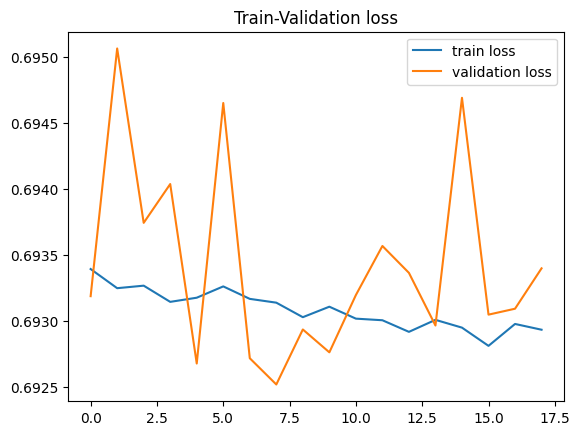

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5114795918367347, 'precision': 0.5114795918367347, 'f1': 0.5114795918367347, 'accuracy': 0.5114795918367347}
MALE {'recall': 0.03125, 'precision': 0.03125, 'f1': 0.03125, 'accuracy': 0.03125}
FEMALE {'recall': 0.9725, 'precision': 0.9725, 'f1': 0.9725, 'accuracy': 0.9725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48484848484848486, 'precision': 0.48484848484848486, 'f1': 0.48484848484848486, 'accuracy': 0.48484848484848486}
MALE {'recall': 0.031630170316301706, 'precision': 0.031630170316301706, 'f1': 0.031630170316301706, 'accuracy': 0.031630170316301706}
FEMALE {'recall': 0.973753280839895, 'precision': 0.973753280839895, 'f1': 0.973753280839895, 'accuracy': 0.973753280839895} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48239895697522817, 'precision': 0.48239895697522817, 'f1': 0.48239895697522817, 'accuracy': 0.48239895697522817}
MALE {'recall': 0.022727272727272728, 'precision

In [29]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5123299319727892, 'precision': 0.5123299319727892, 'f1': 0.5123299319727892, 'accuracy': 0.5123299319727892}
Métricas etiqueta male: {'recall': 0.10243055555555555, 'precision': 0.10243055555555555, 'f1': 0.10243055555555555, 'accuracy': 0.10243055555555555}
Métricas etiqueta female:  {'recall': 0.9058333333333334, 'precision': 0.9058333333333334, 'f1': 0.9058333333333333, 'accuracy': 0.9058333333333334}

 to
Resultado global: {'recall': 0.4831649831649832, 'precision': 0.4831649831649832, 'f1': 0.4831649831649832, 'accuracy': 0.4831649831649832}
Métricas etiqueta male: {'recall': 0.08110300081103, 'precision': 0.08110300081103, 'f1': 0.08110300081103002, 'accuracy': 0.08110300081103}
Métricas etiqueta female:  {'recall': 0.9168853893263342, 'precision': 0.9168853893263342, 'f1': 0.9168853893263342, 'accuracy': 0.9168853893263342}

 as
Resultado global: {'recall': 0.48239895697522817, 'precision': 0.48239895697522817, 'f1': 0.

# AS

In [30]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933663063763741 	 Validation loss: 0.6936860943244676 	 
  1%|          | 574/57400 [00:07<10:12, 92.77it/s]
Epoch 2 	 Training loss: 0.6931825512793006 	 Validation loss: 0.69328455803758 	 
  2%|▏         | 1148/57400 [00:13<09:48, 95.51it/s]
Epoch 3 	 Training loss: 0.693123612150498 	 Validation loss: 0.6924524499198138 	 
  3%|▎         | 1722/57400 [00:20<10:04, 92.15it/s]
Epoch 4 	 Training loss: 0.6930458493764392 	 Validation loss: 0.6933741630133936 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:27<09:53, 92.88it/s]
Epoch 5 	 Training loss: 0.6930755830600287 	 Validation loss: 0.6931347836882381 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:33<09:40, 93.92it/s]
Epoch 6 	 Training loss: 0.6930054325467618 	 Validation loss: 0.6927289033340196 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:40<09:42, 92.57it/s]
Epoch 7 	 Training loss: 0.692805785854519 	 Validation loss: 0.6924300183684139 	 
  7%|

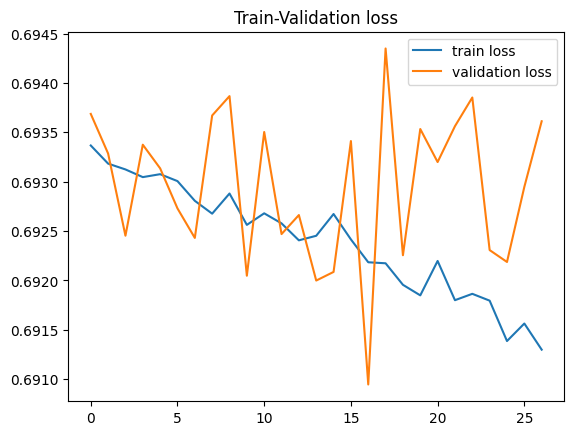

In [31]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4846938775510204, 'precision': 0.4846938775510204, 'f1': 0.4846938775510204, 'accuracy': 0.4846938775510204}
MALE {'recall': 0.2994791666666667, 'precision': 0.2994791666666667, 'f1': 0.2994791666666667, 'accuracy': 0.2994791666666667}
FEMALE {'recall': 0.6625, 'precision': 0.6625, 'f1': 0.6625, 'accuracy': 0.6625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5126262626262627, 'precision': 0.5126262626262627, 'f1': 0.5126262626262627, 'accuracy': 0.5126262626262627}
MALE {'recall': 0.31386861313868614, 'precision': 0.31386861313868614, 'f1': 0.31386861313868614, 'accuracy': 0.31386861313868614}
FEMALE {'recall': 0.7270341207349081, 'precision': 0.7270341207349081, 'f1': 0.7270341207349081, 'accuracy': 0.7270341207349081} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5215123859191656, 'precision': 0.5215123859191656, 'f1': 0.5215123859191656, 'accuracy': 0.5215123859191656}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933346443683013 	 Validation loss: 0.692607236110558 	 
  1%|          | 574/57400 [00:06<10:05, 93.79it/s]
Epoch 2 	 Training loss: 0.693198437370905 	 Validation loss: 0.6938064179178012 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<10:20, 90.72it/s]
Epoch 3 	 Training loss: 0.6931188870805481 	 Validation loss: 0.6925443764460288 	 
  3%|▎         | 1722/57400 [00:19<09:56, 93.29it/s]
Epoch 4 	 Training loss: 0.6930099180558833 	 Validation loss: 0.6931844404188253 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:26<09:51, 93.19it/s]
Epoch 5 	 Training loss: 0.6929388040034198 	 Validation loss: 0.6921111203856387 	 
  5%|▌         | 2870/57400 [00:33<09:35, 94.81it/s]
Epoch 6 	 Training loss: 0.6930200665254627 	 Validation loss: 0.6930068953562591 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:39<09:39, 93.18it/s]
Epoch 7 	 Training loss: 0.6929400559086417 	 Validation loss: 0.6933777746507677 	 

2 

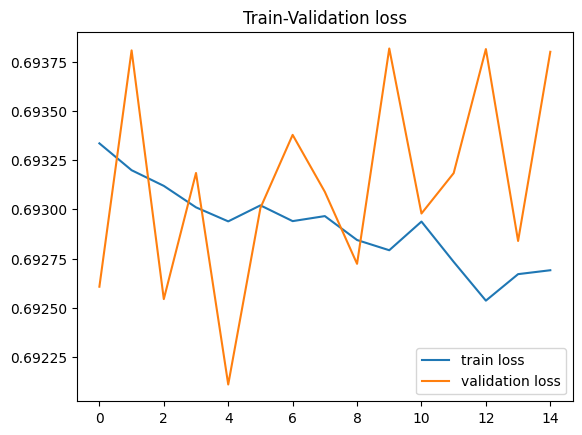

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5051020408163265, 'precision': 0.5051020408163265, 'f1': 0.5051020408163265, 'accuracy': 0.5051020408163265}
MALE {'recall': 0.049479166666666664, 'precision': 0.049479166666666664, 'f1': 0.049479166666666664, 'accuracy': 0.049479166666666664}
FEMALE {'recall': 0.9425, 'precision': 0.9425, 'f1': 0.9425, 'accuracy': 0.9425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48358585858585856, 'precision': 0.48358585858585856, 'f1': 0.48358585858585856, 'accuracy': 0.48358585858585856}
MALE {'recall': 0.051094890510948905, 'precision': 0.051094890510948905, 'f1': 0.05109489051094891, 'accuracy': 0.051094890510948905}
FEMALE {'recall': 0.9501312335958005, 'precision': 0.9501312335958005, 'f1': 0.9501312335958005, 'accuracy': 0.9501312335958005} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4863102998696219, 'precision': 0.4863102998696219, 'f1': 0.4863102998696219, 'accuracy': 0.486310299869621

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934014980385943 	 Validation loss: 0.6926130692837602 	 
  1%|          | 574/57400 [00:06<10:06, 93.66it/s]
Epoch 2 	 Training loss: 0.6932192216351473 	 Validation loss: 0.6942634350162441 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<10:04, 93.07it/s]
Epoch 3 	 Training loss: 0.6931406334302151 	 Validation loss: 0.693438657259537 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:19<10:08, 91.47it/s]
Epoch 4 	 Training loss: 0.6932380346886372 	 Validation loss: 0.6936135645640098 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:26<09:44, 94.29it/s]
Epoch 5 	 Training loss: 0.693167788849475 	 Validation loss: 0.6930039767491616 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:33<09:47, 92.81it/s]
Epoch 6 	 Training loss: 0.6930187653996803 	 Validation loss: 0.6929101176181082 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:39<09:40, 92.95it/s]
Epoch 7 	 Training loss: 0.692

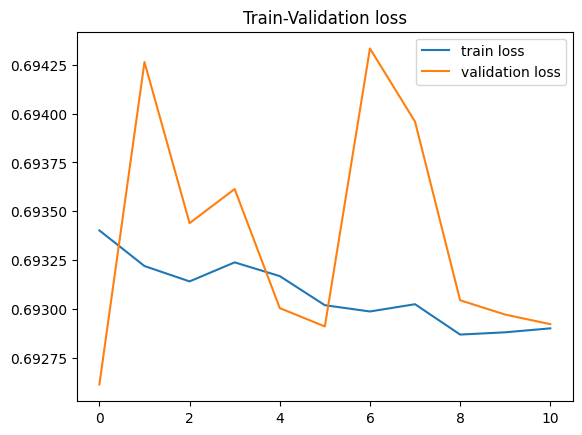

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5153061224489796, 'precision': 0.5153061224489796, 'f1': 0.5153061224489796, 'accuracy': 0.5153061224489796}
MALE {'recall': 0.08072916666666667, 'precision': 0.08072916666666667, 'f1': 0.08072916666666667, 'accuracy': 0.08072916666666667}
FEMALE {'recall': 0.9325, 'precision': 0.9325, 'f1': 0.9325, 'accuracy': 0.9325} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4911616161616162, 'precision': 0.4911616161616162, 'f1': 0.4911616161616162, 'accuracy': 0.4911616161616162}
MALE {'recall': 0.0827250608272506, 'precision': 0.0827250608272506, 'f1': 0.0827250608272506, 'accuracy': 0.0827250608272506}
FEMALE {'recall': 0.931758530183727, 'precision': 0.931758530183727, 'f1': 0.931758530183727, 'accuracy': 0.931758530183727} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4680573663624511, 'precision': 0.4680573663624511, 'f1': 0.4680573663624511, 'accuracy': 0.4680573663624511}
MALE {'recall': 

In [37]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5017006802721088, 'precision': 0.5017006802721088, 'f1': 0.5017006802721088, 'accuracy': 0.5017006802721088}
Métricas etiqueta male: {'recall': 0.14322916666666669, 'precision': 0.14322916666666669, 'f1': 0.14322916666666669, 'accuracy': 0.14322916666666669}
Métricas etiqueta female:  {'recall': 0.8458333333333333, 'precision': 0.8458333333333333, 'f1': 0.8458333333333333, 'accuracy': 0.8458333333333333}

 to
Resultado global: {'recall': 0.4957912457912458, 'precision': 0.4957912457912458, 'f1': 0.4957912457912458, 'accuracy': 0.4957912457912458}
Métricas etiqueta male: {'recall': 0.1492295214922952, 'precision': 0.1492295214922952, 'f1': 0.1492295214922952, 'accuracy': 0.1492295214922952}
Métricas etiqueta female:  {'recall': 0.8696412948381452, 'precision': 0.8696412948381452, 'f1': 0.8696412948381452, 'accuracy': 0.8696412948381452}

 as
Resultado global: {'recall': 0.4919600173837462, 'precision': 0.4919600173837462, 'f1':

# Pruebas hiperparámetros 2

In [38]:
emb_dim = 20
vocab_size = len(word_to_index)
# num_labels = 2
lstm_hidden_dim = 64

## ABOUT

In [39]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6813699616580059 	 Validation loss: 0.6820704664214182 	 
  1%|          | 574/57400 [00:04<07:26, 127.28it/s]
Epoch 2 	 Training loss: 0.6764194706798846 	 Validation loss: 0.6737821162757227 	 
  2%|▏         | 1148/57400 [00:09<07:18, 128.23it/s]
Epoch 3 	 Training loss: 0.6631644313136045 	 Validation loss: 0.6562004119662915 	 
  3%|▎         | 1722/57400 [00:14<07:09, 129.66it/s]
Epoch 4 	 Training loss: 0.6515552626877297 	 Validation loss: 0.6466683735281734 	 
  4%|▍         | 2296/57400 [00:19<07:09, 128.20it/s]
Epoch 5 	 Training loss: 0.6438611419774098 	 Validation loss: 0.6400985778388331 	 
  5%|▌         | 2870/57400 [00:24<07:04, 128.58it/s]
Epoch 6 	 Training loss: 0.6370848195062697 	 Validation loss: 0.6334111043962382 	 
  6%|▌         | 3444/57400 [00:29<07:04, 127.00it/s]
Epoch 7 	 Training loss: 0.6306545504917251 	 Validation loss: 0.6266378275418686 	 
  7%|▋         | 4018/57400 [00:33<06:57, 127.99it/s]
Epoch 8 	 Training loss: 0.6

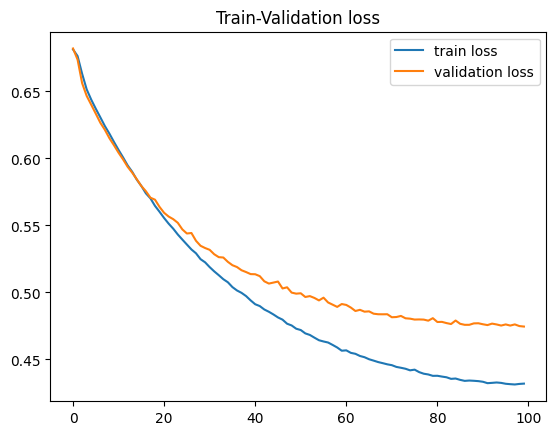

In [40]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [41]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7104591836734694, 'precision': 0.7104591836734694, 'f1': 0.7104591836734694, 'accuracy': 0.7104591836734694}
MALE {'recall': 0.8515625, 'precision': 0.8515625, 'f1': 0.8515625, 'accuracy': 0.8515625}
FEMALE {'recall': 0.575, 'precision': 0.575, 'f1': 0.575, 'accuracy': 0.575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5858585858585859, 'precision': 0.5858585858585859, 'f1': 0.5858585858585859, 'accuracy': 0.5858585858585859}
MALE {'recall': 0.6861313868613139, 'precision': 0.6861313868613139, 'f1': 0.6861313868613139, 'accuracy': 0.6861313868613139}
FEMALE {'recall': 0.4776902887139108, 'precision': 0.4776902887139108, 'f1': 0.4776902887139108, 'accuracy': 0.4776902887139108} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.621903520208605, 'precision': 0.621903520208605, 'f1': 0.621903520208605, 'accuracy': 0.621903520208605}
MALE {'recall': 0.7121212121212122, 'precision': 0.712121212

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6813968788663685 	 Validation loss: 0.6813114972437843 	 
  1%|          | 574/57400 [00:04<07:22, 128.29it/s]
Epoch 2 	 Training loss: 0.6732985605761564 	 Validation loss: 0.6679274510529082 	 
  2%|▏         | 1148/57400 [00:09<07:17, 128.50it/s]
Epoch 3 	 Training loss: 0.6565648680779992 	 Validation loss: 0.6561763882637024 	 
  3%|▎         | 1722/57400 [00:14<07:25, 125.06it/s]
Epoch 4 	 Training loss: 0.6471322242183553 	 Validation loss: 0.648202821359796 	 
  4%|▍         | 2296/57400 [00:19<07:12, 127.31it/s]
Epoch 5 	 Training loss: 0.6394268814279642 	 Validation loss: 0.6408911498926454 	 
  5%|▌         | 2870/57400 [00:24<07:06, 127.93it/s]
Epoch 6 	 Training loss: 0.6327290194375175 	 Validation loss: 0.6348558341042471 	 
  6%|▌         | 3444/57400 [00:29<07:03, 127.54it/s]
Epoch 7 	 Training loss: 0.6259434368552231 	 Validation loss: 0.6281529897350376 	 
  7%|▋         | 4018/57400 [00:34<07:04, 125.61it/s]
Epoch 8 	 Training loss: 0.61

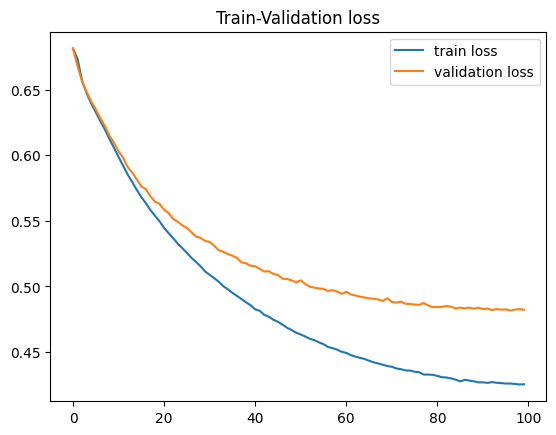

In [42]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [43]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7372448979591837, 'precision': 0.7372448979591837, 'f1': 0.7372448979591837, 'accuracy': 0.7372448979591837}
MALE {'recall': 0.7734375, 'precision': 0.7734375, 'f1': 0.7734375, 'accuracy': 0.7734375}
FEMALE {'recall': 0.7025, 'precision': 0.7025, 'f1': 0.7025, 'accuracy': 0.7025} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5416666666666666, 'precision': 0.5416666666666666, 'f1': 0.5416666666666666, 'accuracy': 0.5416666666666666}
MALE {'recall': 0.5644768856447688, 'precision': 0.5644768856447688, 'f1': 0.5644768856447688, 'accuracy': 0.5644768856447688}
FEMALE {'recall': 0.5170603674540682, 'precision': 0.5170603674540682, 'f1': 0.5170603674540682, 'accuracy': 0.5170603674540682} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6140808344198174, 'precision': 0.6140808344198174, 'f1': 0.6140808344198174, 'accuracy': 0.6140808344198174}
MALE {'recall': 0.6313131313131313, 'precision': 0.6

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6805148070697585 	 Validation loss: 0.6808409973726435 	 
  1%|          | 574/57400 [00:04<07:31, 125.97it/s]
Epoch 2 	 Training loss: 0.6752569902857006 	 Validation loss: 0.6706622586411944 	 
  2%|▏         | 1148/57400 [00:09<07:15, 129.24it/s]
Epoch 3 	 Training loss: 0.6622871025514104 	 Validation loss: 0.6602712546364736 	 
  3%|▎         | 1722/57400 [00:14<07:16, 127.69it/s]
Epoch 4 	 Training loss: 0.6539182176988715 	 Validation loss: 0.6546372720750712 	 
  4%|▍         | 2296/57400 [00:19<07:07, 128.82it/s]
Epoch 5 	 Training loss: 0.646511717436621 	 Validation loss: 0.6457900425135079 	 
  5%|▌         | 2870/57400 [00:24<07:06, 127.81it/s]
Epoch 6 	 Training loss: 0.6393455307450444 	 Validation loss: 0.6395011160333278 	 
  6%|▌         | 3444/57400 [00:29<07:02, 127.68it/s]
Epoch 7 	 Training loss: 0.63138225280034 	 Validation loss: 0.6323861318119501 	 
  7%|▋         | 4018/57400 [00:34<07:03, 126.04it/s]
Epoch 8 	 Training loss: 0.6237

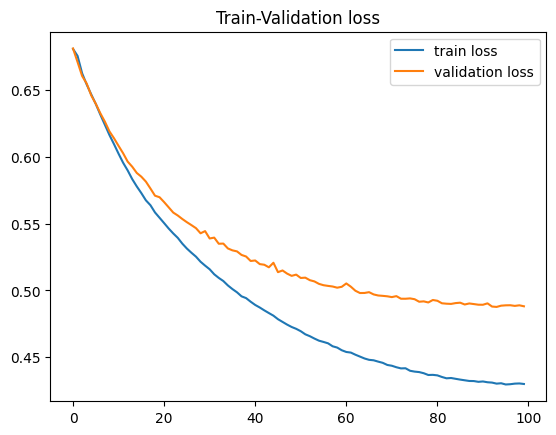

In [44]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [45]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6811224489795918, 'precision': 0.6811224489795918, 'f1': 0.6811224489795918, 'accuracy': 0.6811224489795918}
MALE {'recall': 0.7604166666666666, 'precision': 0.7604166666666666, 'f1': 0.7604166666666666, 'accuracy': 0.7604166666666666}
FEMALE {'recall': 0.605, 'precision': 0.605, 'f1': 0.605, 'accuracy': 0.605} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5606060606060606, 'precision': 0.5606060606060606, 'f1': 0.5606060606060606, 'accuracy': 0.5606060606060606}
MALE {'recall': 0.6180048661800487, 'precision': 0.6180048661800487, 'f1': 0.6180048661800487, 'accuracy': 0.6180048661800487}
FEMALE {'recall': 0.49868766404199477, 'precision': 0.49868766404199477, 'f1': 0.49868766404199477, 'accuracy': 0.49868766404199477} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6140808344198174, 'precision': 0.6140808344198174, 'f1': 0.6140808344198174, 'accuracy': 0.6140808344198174}
MALE {'recall': 

In [46]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7096088435374149, 'precision': 0.7096088435374149, 'f1': 0.7096088435374149, 'accuracy': 0.7096088435374149}
Métricas etiqueta male: {'recall': 0.7951388888888888, 'precision': 0.7951388888888888, 'f1': 0.7951388888888888, 'accuracy': 0.7951388888888888}
Métricas etiqueta female:  {'recall': 0.6275, 'precision': 0.6275, 'f1': 0.6275, 'accuracy': 0.6275}

 to
Resultado global: {'recall': 0.5627104377104377, 'precision': 0.5627104377104377, 'f1': 0.5627104377104377, 'accuracy': 0.5627104377104377}
Métricas etiqueta male: {'recall': 0.6228710462287105, 'precision': 0.6228710462287105, 'f1': 0.6228710462287105, 'accuracy': 0.6228710462287105}
Métricas etiqueta female:  {'recall': 0.4978127734033246, 'precision': 0.4978127734033246, 'f1': 0.4978127734033246, 'accuracy': 0.4978127734033246}

 as
Resultado global: {'recall': 0.6166883963494133, 'precision': 0.6166883963494133, 'f1': 0.6166883963494133, 'accuracy': 0.6166883963494133}

## TO

In [47]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932905008983944 	 Validation loss: 0.6928657919673596 	 
  1%|          | 574/57400 [00:05<08:25, 112.46it/s]
Epoch 2 	 Training loss: 0.693172780375032 	 Validation loss: 0.6923725665625879 	 
  2%|▏         | 1148/57400 [00:11<08:36, 108.96it/s]
Epoch 3 	 Training loss: 0.693219354136065 	 Validation loss: 0.6924406977023109 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:16<08:24, 110.44it/s]
Epoch 4 	 Training loss: 0.6931229594069491 	 Validation loss: 0.6928412651611586 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:19, 110.42it/s]
Epoch 5 	 Training loss: 0.6931723270059047 	 Validation loss: 0.6928051851563535 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:28<08:17, 109.68it/s]
Epoch 6 	 Training loss: 0.6931558777854002 	 Validation loss: 0.6933193610886396 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:12, 109.55it/s]
Epoch 7 	 Training loss: 0.6931487060174709 	 Validat

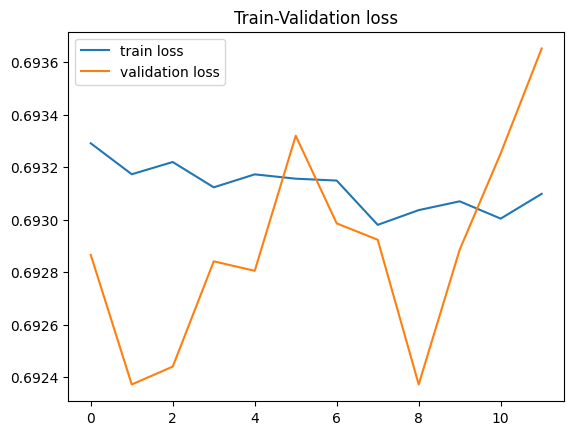

In [48]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [49]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
MALE {'recall': 0.0026041666666666665, 'precision': 0.0026041666666666665, 'f1': 0.0026041666666666665, 'accuracy': 0.0026041666666666665}
FEMALE {'recall': 0.9925, 'precision': 0.9925, 'f1': 0.9925, 'accuracy': 0.9925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.007575757575757576, 'precision': 0.007575757575757576, 'f1': 0.007575757575757576, 'accuracy': 0.00757

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933265321138429 	 Validation loss: 0.6933529417393571 	 
  1%|          | 574/57400 [00:05<08:30, 111.35it/s]
Epoch 2 	 Training loss: 0.6932965846219544 	 Validation loss: 0.6931932962546914 	 
  2%|▏         | 1148/57400 [00:11<08:22, 112.03it/s]
Epoch 3 	 Training loss: 0.693134534442051 	 Validation loss: 0.6938410845853514 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:16<08:35, 108.01it/s]
Epoch 4 	 Training loss: 0.6931302429076271 	 Validation loss: 0.6929959786140313 	 
  4%|▍         | 2296/57400 [00:22<08:20, 110.18it/s]
Epoch 5 	 Training loss: 0.6930474573519172 	 Validation loss: 0.693153337906983 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:28<08:15, 109.97it/s]
Epoch 6 	 Training loss: 0.6930673075677626 	 Validation loss: 0.6927285032757258 	 
  6%|▌         | 3444/57400 [00:33<08:18, 108.25it/s]
Epoch 7 	 Training loss: 0.6930566533932703 	 Validation loss: 0.6923029210607884 	 
  7%|▋         | 4018/5740

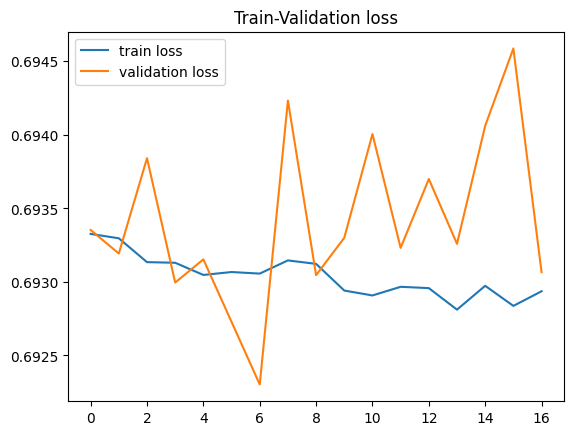

In [50]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [51]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.1171875, 'precision': 0.1171875, 'f1': 0.1171875, 'accuracy': 0.1171875}
FEMALE {'recall': 0.8675, 'precision': 0.8675, 'f1': 0.8675, 'accuracy': 0.8675} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4962121212121212, 'precision': 0.4962121212121212, 'f1': 0.4962121212121212, 'accuracy': 0.4962121212121212}
MALE {'recall': 0.12408759124087591, 'precision': 0.12408759124087591, 'f1': 0.12408759124087591, 'accuracy': 0.12408759124087591}
FEMALE {'recall': 0.8976377952755905, 'precision': 0.8976377952755905, 'f1': 0.8976377952755905, 'accuracy': 0.8976377952755905} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.485006518904824, 'precision': 0.485006518904824, 'f1': 0.485006518904824, 'accuracy': 0.485006518904824}
MALE {'recall': 0.08080808080808081, 'precision': 0.08080808080808081, 'f1': 0.08080808080808081, 'accuracy': 0.

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932249023523895 	 Validation loss: 0.6928835662744813 	 
  1%|          | 574/57400 [00:05<08:26, 112.28it/s]
Epoch 2 	 Training loss: 0.6931829307137466 	 Validation loss: 0.6924471046965001 	 
  2%|▏         | 1148/57400 [00:11<08:30, 110.30it/s]
Epoch 3 	 Training loss: 0.6931558397796511 	 Validation loss: 0.6924104448092185 	 
  3%|▎         | 1722/57400 [00:16<08:16, 112.22it/s]
Epoch 4 	 Training loss: 0.6931671313292473 	 Validation loss: 0.6925934805708417 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:22, 109.72it/s]
Epoch 5 	 Training loss: 0.6931873088514348 	 Validation loss: 0.6933358240935762 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:27<08:18, 109.49it/s]
Epoch 6 	 Training loss: 0.6931624104129313 	 Validation loss: 0.6926880923368163 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:12, 109.56it/s]
Epoch 7 	 Training loss: 0.6931194351525257 	 Validation loss: 0.693086340265759

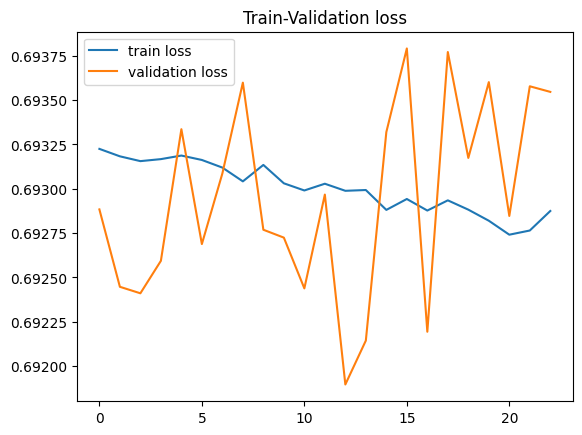

In [52]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [53]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5051020408163265, 'precision': 0.5051020408163265, 'f1': 0.5051020408163265, 'accuracy': 0.5051020408163265}
MALE {'recall': 0.21614583333333334, 'precision': 0.21614583333333334, 'f1': 0.21614583333333331, 'accuracy': 0.21614583333333334}
FEMALE {'recall': 0.7825, 'precision': 0.7825, 'f1': 0.7825, 'accuracy': 0.7825} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.2384428223844282, 'precision': 0.2384428223844282, 'f1': 0.2384428223844282, 'accuracy': 0.2384428223844282}
FEMALE {'recall': 0.7821522309711286, 'precision': 0.7821522309711286, 'f1': 0.7821522309711286, 'accuracy': 0.7821522309711286} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4863102998696219, 'precision': 0.4863102998696219, 'f1': 0.4863102998696219, 'accuracy': 0.4863102998696219}
MALE {'recall': 0.19696969696969696, 'precision': 0.19696969696969696, '

In [54]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5042517006802721, 'precision': 0.5042517006802721, 'f1': 0.5042517006802721, 'accuracy': 0.5042517006802721}
Métricas etiqueta male: {'recall': 0.11197916666666667, 'precision': 0.11197916666666667, 'f1': 0.11197916666666666, 'accuracy': 0.11197916666666667}
Métricas etiqueta female:  {'recall': 0.8808333333333334, 'precision': 0.8808333333333334, 'f1': 0.8808333333333334, 'accuracy': 0.8808333333333334}

 to
Resultado global: {'recall': 0.49242424242424243, 'precision': 0.49242424242424243, 'f1': 0.49242424242424243, 'accuracy': 0.49242424242424243}
Métricas etiqueta male: {'recall': 0.12084347120843471, 'precision': 0.12084347120843471, 'f1': 0.12084347120843471, 'accuracy': 0.12084347120843471}
Métricas etiqueta female:  {'recall': 0.8932633420822397, 'precision': 0.8932633420822397, 'f1': 0.8932633420822397, 'accuracy': 0.8932633420822397}

 as
Resultado global: {'recall': 0.485006518904824, 'precision': 0.485006518904824,

## AS

In [55]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933039477685603 	 Validation loss: 0.693013380139561 	 
  1%|          | 574/57400 [00:05<08:25, 112.37it/s]
Epoch 2 	 Training loss: 0.6932505657863949 	 Validation loss: 0.6929373720944938 	 
  2%|▏         | 1148/57400 [00:11<08:33, 109.61it/s]
Epoch 3 	 Training loss: 0.6932024660841514 	 Validation loss: 0.6932202102774281 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:16<08:27, 109.81it/s]
Epoch 4 	 Training loss: 0.6932156548059776 	 Validation loss: 0.692230163994482 	 
  4%|▍         | 2296/57400 [00:22<08:19, 110.36it/s]
Epoch 5 	 Training loss: 0.6931008114008953 	 Validation loss: 0.6928220765065338 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:27<08:15, 110.00it/s]
Epoch 6 	 Training loss: 0.6930673199248231 	 Validation loss: 0.693057525966127 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:11, 109.80it/s]
Epoch 7 	 Training loss: 0.6930054704486701 	 Validation loss: 0.6930192789788974 	

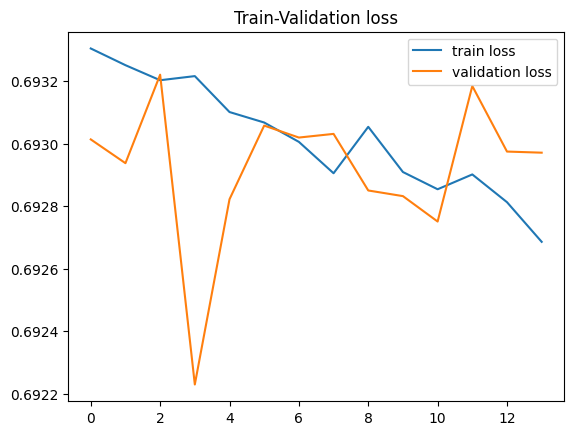

In [56]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [57]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
MALE {'recall': 0.036458333333333336, 'precision': 0.036458333333333336, 'f1': 0.036458333333333336, 'accuracy': 0.036458333333333336}
FEMALE {'recall': 0.96, 'precision': 0.96, 'f1': 0.96, 'accuracy': 0.96} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.476010101010101, 'precision': 0.476010101010101, 'f1': 0.476010101010101, 'accuracy': 0.476010101010101}
MALE {'recall': 0.031630170316301706, 'precision': 0.031630170316301706, 'f1': 0.031630170316301706, 'accuracy': 0.031630170316301706}
FEMALE {'recall': 0.9553805774278216, 'precision': 0.9553805774278216, 'f1': 0.9553805774278216, 'accuracy': 0.9553805774278216} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49022164276401564, 'precision': 0.49022164276401564, 'f1': 0.49022164276401564, 'accuracy': 0.49022164276401564}
MALE {'r

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693400955781704 	 Validation loss: 0.6931934174844774 	 
  1%|          | 574/57400 [00:05<08:26, 112.21it/s]
Epoch 2 	 Training loss: 0.6932486123324272 	 Validation loss: 0.694177517446421 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:11<08:35, 109.18it/s]
Epoch 3 	 Training loss: 0.6931643722780075 	 Validation loss: 0.6931832695411424 	 
  3%|▎         | 1722/57400 [00:16<08:31, 108.92it/s]
Epoch 4 	 Training loss: 0.6931847072229153 	 Validation loss: 0.6934332665750536 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:11, 112.19it/s]
Epoch 5 	 Training loss: 0.6931176042307544 	 Validation loss: 0.6924717042405727 	 
  5%|▌         | 2870/57400 [00:27<08:19, 109.11it/s]
Epoch 6 	 Training loss: 0.6930439059950333 	 Validation loss: 0.6922272777153273 	 
  6%|▌         | 3444/57400 [00:33<08:04, 111.36it/s]
Epoch 7 	 Training loss: 0.6931083385121947 	 Validation loss: 0.6929606290186866 	 

1 epoch without improveme

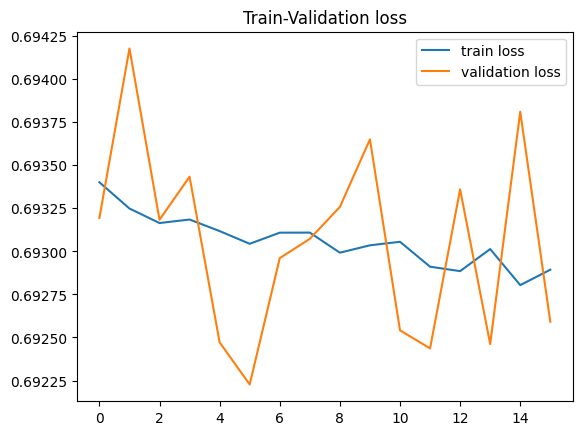

In [58]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [59]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.0390625, 'precision': 0.0390625, 'f1': 0.0390625, 'accuracy': 0.0390625}
FEMALE {'recall': 0.9425, 'precision': 0.9425, 'f1': 0.9425, 'accuracy': 0.9425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0364963503649635, 'precision': 0.0364963503649635, 'f1': 0.0364963503649635, 'accuracy': 0.0364963503649635}
FEMALE {'recall': 0.9606299212598425, 'precision': 0.9606299212598425, 'f1': 0.9606299212598425, 'accuracy': 0.9606299212598425} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4863102998696219, 'precision': 0.4863102998696219, 'f1': 0.4863102998696219, 'accuracy': 0.4863102998696219}
MALE {'recall': 0.027777777777777776, 'precision': 0.027777777777777776, 'f1': 0.027777777777777776, 'accuracy':

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932578422258955 	 Validation loss: 0.6933141987202531 	 
  1%|          | 574/57400 [00:05<08:33, 110.56it/s]
Epoch 2 	 Training loss: 0.6931601194762187 	 Validation loss: 0.6938596054659052 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:11<08:23, 111.76it/s]
Epoch 3 	 Training loss: 0.6931230526560275 	 Validation loss: 0.6932846439086785 	 
  3%|▎         | 1722/57400 [00:16<08:36, 107.89it/s]
Epoch 4 	 Training loss: 0.6931382338759791 	 Validation loss: 0.6933459972931166 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:21, 109.90it/s]
Epoch 5 	 Training loss: 0.6931142127887713 	 Validation loss: 0.6931869347216719 	 
  5%|▌         | 2870/57400 [00:28<08:19, 109.08it/s]
Epoch 6 	 Training loss: 0.6931281742941627 	 Validation loss: 0.6930339558649872 	 
  6%|▌         | 3444/57400 [00:33<08:07, 110.77it/s]
Epoch 7 	 Training loss: 0.6930309506035848 	 Validation loss: 0.6926361524452598 	 
  7%|▋         | 4018/57

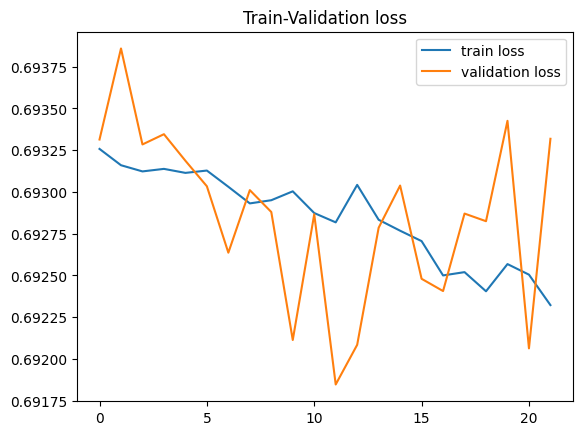

In [60]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [61]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
MALE {'recall': 0.14583333333333334, 'precision': 0.14583333333333334, 'f1': 0.14583333333333334, 'accuracy': 0.14583333333333334}
FEMALE {'recall': 0.855, 'precision': 0.855, 'f1': 0.855, 'accuracy': 0.855} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.494949494949495, 'precision': 0.494949494949495, 'f1': 0.494949494949495, 'accuracy': 0.494949494949495}
MALE {'recall': 0.10462287104622871, 'precision': 0.10462287104622871, 'f1': 0.10462287104622871, 'accuracy': 0.10462287104622871}
FEMALE {'recall': 0.916010498687664, 'precision': 0.916010498687664, 'f1': 0.916010498687664, 'accuracy': 0.916010498687664} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'recall': 0.11

In [62]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5051020408163266, 'precision': 0.5051020408163266, 'f1': 0.5051020408163266, 'accuracy': 0.5051020408163266}
Métricas etiqueta male: {'recall': 0.07378472222222222, 'precision': 0.07378472222222222, 'f1': 0.07378472222222222, 'accuracy': 0.07378472222222222}
Métricas etiqueta female:  {'recall': 0.9191666666666667, 'precision': 0.9191666666666667, 'f1': 0.9191666666666667, 'accuracy': 0.9191666666666667}

 to
Resultado global: {'recall': 0.484006734006734, 'precision': 0.484006734006734, 'f1': 0.484006734006734, 'accuracy': 0.484006734006734}
Métricas etiqueta male: {'recall': 0.0575831305758313, 'precision': 0.0575831305758313, 'f1': 0.0575831305758313, 'accuracy': 0.0575831305758313}
Métricas etiqueta female:  {'recall': 0.9440069991251093, 'precision': 0.9440069991251093, 'f1': 0.9440069991251093, 'accuracy': 0.9440069991251093}

 as
Resultado global: {'recall': 0.48587570621468923, 'precision': 0.48587570621468923, 'f1': 0